# Bone Age Prediction

## Deep CNN Approaches for Predicting Bone Age from Hand X-ray Radiographs

Bone age prediction is crucial for diagnosing and managing various pediatric disorders. Accurate bone age assessment helps in identifying growth abnormalities, determining appropriate treatment plans for children with growth disorders, and monitoring the effectiveness of growth-promoting therapies. Moreover, it aids in predicting the onset of puberty and can be essential for evaluating children with endocrine disorders, such as hypothyroidism and growth hormone deficiencies. By leveraging deep CNN approaches for predicting bone age from hand X-ray radiographs, medical professionals can achieve more precise and automated assessments, improving patient outcomes and reducing the workload on radiologits.
ient care.

### Part One: Training Phase

In this part we prepare the dataset and train our models with both approaches and save the trained models then we analyze the results.


**Important Point: Part one is completed during the development of the project, so if you intend to change the hyperparameters you have to run part one again and wait for approximately 9 hours for both networks to be trained. If not, you can start from Part Two.**

In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

We check if GPU is available in the runtime.

In [2]:
tf.config.list_physical_devices('GPU')

2023-02-13 10:35:45.271171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 10:35:45.375177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 10:35:45.376005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Here we define some functions to work with directories and files.

In [3]:
def get_file_name(dir):
    return os.listdir(dir)

def get_file_absolute_path(dir):
    file_names = os.listdir(dir)
    file_absolute_path = []
    for file_name in file_names:
        file_absolute_path.append(dir + file_name)
    return file_absolute_path

We define the root directory of the dataset and create the path of each dataset section including data and labels.

In [4]:
dir_root = '/kaggle/input/human-data-dataset/Bone Age Dataset/Bone Age Dataset/'

training_root = 'Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/'
test_root = 'Bone Age Test Set/'

data_path = 'data/'
label_path = 'labels/'

training_dataset_path = dir_root + training_root + data_path
validation_dataset_path = dir_root + validation_root + data_path
test_dataset_path = dir_root + test_root + data_path

training_labels_path = dir_root + training_root + label_path
validation_labels_path = dir_root + validation_root + label_path
test_labels_path = dir_root + test_root + label_path

# Dataset
For our project, we will use the training hands’ X-ray images (digital and scanned) from two U.S. hospitals. The labels are a CSV file containing the bone age (to be predicted in the month) and the gender (useful additional information) for classification which is not our case.
The main dataset consists of 12,611 color images (512 x 512 x 3) and each image is annotated with a continuous label indicating the bone age in the month.

Here we read the labels and drop the gender column then we convert the pandas object to a python dictionary such that each image ID is associated with a continuous label.

In [5]:
training_labels = pd.read_csv(training_labels_path + get_file_name(training_labels_path)[0]).drop(columns=['male'])
validation_labels = pd.read_csv(validation_labels_path + get_file_name(validation_labels_path)[0]).drop(columns=['male'])
test_labels = pd.read_csv(test_labels_path + get_file_name(test_labels_path)[0]).drop(columns=['Sex'])

def convert_pandas_label_to_dict(dataframe):
    np_array = dataframe.values
    result = {}
    for indx, value in np_array:
        result[int(indx)] = value
    return result

training_labels = convert_pandas_label_to_dict(training_labels)
validation_labels = convert_pandas_label_to_dict(validation_labels)
test_labels = convert_pandas_label_to_dict(test_labels)

In this Part, we create a data frame consisting of Two columns. The first one is the absolute path of the file and the second one is the associated target value of the image.

In [6]:
def create_dataset_datafram(dir, labels):
    data_container = {}
    paths = get_file_absolute_path(dir)
    for path in paths:
        data_container[path] = labels[int(re.findall('[0-9]+', path)[0])]
    return pd.DataFrame(list(data_container.items()), columns = ['file_absolute_path', 'label'])

training_dataframe = create_dataset_datafram(training_dataset_path, training_labels)
validation_dataframe = create_dataset_datafram(validation_dataset_path, validation_labels)
test_dataframe = create_dataset_datafram(test_dataset_path, test_labels)

Finally, we create the dataset with the Image Generator class. For the training set, we use rescaling and random horizontal and vertical flips to make model more accurate.

For validation and test set, we only use rescaling.

The size of the images will be set to `256 x 256` and the batch size is `32`.

In [7]:
SIZE = 256
batch_size = 32

training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255.)
val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_dataset = training_data_generator.flow_from_dataframe(
    dataframe=training_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    classes=None,
    class_mode='raw')

validation_dataset = val_data_generator.flow_from_dataframe(
    dataframe=validation_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=None,
    shuffle=False,
    classes=None,
    class_mode='raw')

test_dataset = val_data_generator.flow_from_dataframe(
    dataframe=test_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=None,
    shuffle=False,
    classes=None,
    class_mode='raw')

Found 12611 validated image filenames.
Found 1425 validated image filenames.
Found 200 validated image filenames.


In this section, to be sure everything is fine, we print the size of X_set, and y_set for training, validation, and test set. Then we randomly choose Three images from the test set and plot them.

Batch size: 32
X_train shape: (32, 256, 256, 3)
y_train shape: (32,)
X_val shape: (32, 256, 256, 3)
y_val shape: (32,)
X_test shape: (32, 256, 256, 3)
y_test shape: (32,)


LABEL: 138.98005954860508


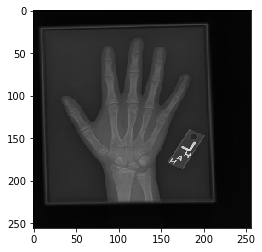



LABEL: 191.97491555726504


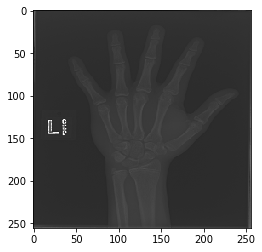



LABEL: 163.8711117389303


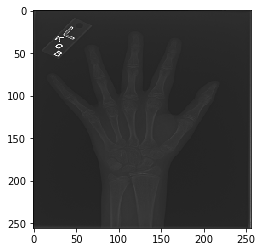

In [8]:
print('Batch size: ' + str(batch_size))
X_train_sample = train_dataset.__getitem__(0)[0]
y_train_sample = train_dataset.__getitem__(0)[1]
print ('X_train shape: '  + str(X_train_sample.shape))
print ('y_train shape: ' + str(y_train_sample.shape))
X_val_sample = validation_dataset.__getitem__(0)[0]
y_val_sample = validation_dataset.__getitem__(0)[1]
print ('X_val shape: '  + str(X_val_sample.shape))
print ('y_val shape: ' + str(y_val_sample.shape))
index = random.randint(0, 5)
X_test_sample = test_dataset.__getitem__(index)[0]
y_test_sample = test_dataset.__getitem__(index)[1]
print ('X_test shape: '  + str(X_test_sample.shape))
print ('y_test shape: ' + str(y_test_sample.shape))
print("\n")

def plot_image(X_input, labels):
    plt.imshow(X_input, cmap=plt.cm.gray_r, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

for i in range(3):
    plot_image(X_test_sample[i], y_test_sample[i])
    print("\n")

Here we formulate the train, validation and test steps duraing training and evaluation phase.

In [9]:
# In each epoch, 32 samples will be fed to the model and 395 * 2 = 790 (train_dataset.n / batch_size = 395) feedforward-backpropagate operation will be executed to update the model parameters.
train_steps = int(np.ceil(train_dataset.n / batch_size))

# The same for validation set
val_steps = int(np.ceil(validation_dataset.n / batch_size))

# The same for test set
test_steps = int(np.ceil(test_dataset.n / batch_size))

# First Approach
## ResNet-50 For Bone Age Prediction

In this approach, we implement the ResNet-50 from scratch for the regression task.



**We consider the following points:**

- All hidden layers use GELU as their activation function
- The final layer uses Linear as its activation function
- The Adam optimizer is used to minimize the gradient
- The Mean Squared Logarithmic Error is used for the loss function
- The RMSE, MAPE and, R Squared metrics are used to evaluate model performance

In [11]:
class ResNet50Regressor:

    def __init__(self, activation):
        self.activation = activation


    def __identity_block(self, X, f, filters, stage, block):

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        F1, F2, F3 = filters

        X_shortcut = X

        X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

        X = tf.keras.layers.Add()([X, X_shortcut])# SKIP Connection

        return tf.keras.layers.Activation(self.activation)(X)


    def __convolutional_block(self, X, f, filters, stage, block, s=2):

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        F1, F2, F3 = filters

        X_shortcut = X

        X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

        X_shortcut = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
        X_shortcut = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

        X = tf.keras.layers.Add()([X, X_shortcut])# SKIP Connection

        return tf.keras.layers.Activation(self.activation)(X)


    def __ResNet50(self, input_shape):

        X_input = tf.keras.layers.Input(input_shape)

        X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

        X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = tf.keras.layers.Activation(self.activation)(X)
        X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = self.__convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
        X = self.__identity_block(X, 3, [64, 64, 256], stage=2, block='b')
        X = self.__identity_block(X, 3, [64, 64, 256], stage=2, block='c')


        X = self.__convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='b')
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='c')
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='d')

        X = self.__convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

        X = self.__convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
        X = self.__identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
        X = self.__identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

        X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        return tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')


    def create_model(self, input_shape):
        base_model = self.__ResNet50(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(256, activation=self.activation, name='fc1')(fc)
        fc = tf.keras.layers.Dense(128, activation=self.activation, name='fc2')(fc)
        fc = tf.keras.layers.Dense(64, activation=self.activation, name='fc3')(fc)
        fc = tf.keras.layers.Dense(32, activation=self.activation, name='fc4')(fc)
        fc = tf.keras.layers.Dense(1, activation='linear', name='fc5')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='ResNet50_Regressor')


prepared_resnet50_model = ResNet50Regressor(activation='gelu').create_model(input_shape=(SIZE, SIZE, 3))

2023-02-12 16:35:46.642274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 16:35:46.642708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 16:35:46.643562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 16:35:46.644215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Here we summarize the model and architecture.

In [12]:
prepared_resnet50_model.summary()

Model: "ResNet50_Regressor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
_________________________________________________________________________________

Our model has more than `32` million parameters!

Then we plot the model architecture for better understanding.

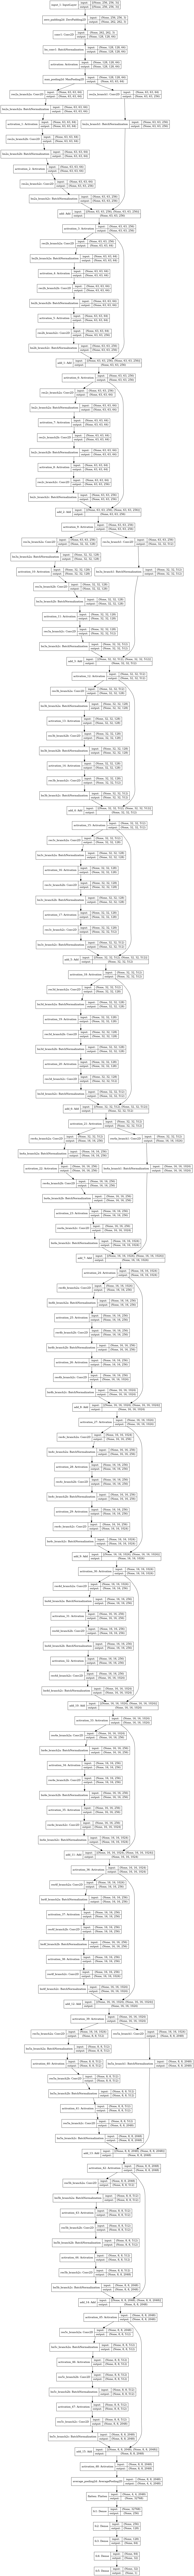

In [13]:
tf.keras.utils.plot_model(prepared_resnet50_model, show_shapes=True, to_file='resnet50.png')

We define the custom metric `R Squared` for our problem.

In [13]:
def r_squared(y_true, y_pred):
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    return 1. - tf.divide(unexplained_error, total_error)

And the early stopping callback for the time that the performance is not improving.

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True)

In this function, we train our model with the chosen hyperparameters and save the trained model for future uses.

In [16]:
def train_resnet50_model(prepared_model, training_data, optimizer='adam', loss_fn='mean_squared_logarithmic_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), r_squared], callbacks=[es], num_epochs=100):
    files = get_file_name('/kaggle/working/')
    if 'resnet50regressor.h5' in files:
        prepared_model = tf.keras.models.load_model('/kaggle/working/resnet50regressor.h5', custom_objects={'r_squared': r_squared})
        history = np.load('/kaggle/working/resnet50history.npy', allow_pickle=True).item()
    else:
        prepared_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
        history = prepared_model.fit(training_data, epochs=num_epochs, callbacks=callbacks, steps_per_epoch=train_steps, validation_data=validation_dataset, validation_steps=val_steps)
        prepared_model.save('/kaggle/working/resnet50regressor.h5')
        np.save('/kaggle/working/resnet50history.npy', history.history)
    return prepared_model, history


resnet50_model, resnet50_history = train_resnet50_model(prepared_resnet50_model, train_dataset, num_epochs=120)

2023-02-12 16:37:23.798030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120


2023-02-12 16:37:34.370453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


395/395 [==============================] - 163s 370ms/step - loss: 0.2372 - root_mean_squared_error: 45.2859 - mean_absolute_percentage_error: 40.4858 - r_squared: -0.2697 - val_loss: 0.2069 - val_root_mean_squared_error: 47.0401 - val_mean_absolute_percentage_error: 43.3354 - val_r_squared: -0.3382
Epoch 2/120
395/395 [==============================] - 141s 356ms/step - loss: 0.1344 - root_mean_squared_error: 36.1371 - mean_absolute_percentage_error: 31.9601 - r_squared: 0.1818 - val_loss: 0.1737 - val_root_mean_squared_error: 41.4960 - val_mean_absolute_percentage_error: 36.2905 - val_r_squared: -0.0441
Epoch 3/120
395/395 [==============================] - 138s 350ms/step - loss: 0.1213 - root_mean_squared_error: 34.3702 - mean_absolute_percentage_error: 29.4694 - r_squared: 0.2484 - val_loss: 0.1639 - val_root_mean_squared_error: 41.1090 - val_mean_absolute_percentage_error: 33.9251 - val_r_squared: -0.0309
Epoch 4/120
395/395 [==============================] - 139s 351ms/step - lo

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In this section we defined some functions to plot the loss and metrics of both train and validation set.

In [ ]:
def plot_loss_curve(history):
    if not isinstance(history, dict):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    else:
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()


def plot_rmse_metric_curve(history):
    if not isinstance(history, dict):
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('Model Root Mean Squared Error')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    else:
        plt.plot(history['root_mean_squared_error'])
        plt.plot(history['val_root_mean_squared_error'])
        plt.title('Root Mean Squared Error')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()


def plot_mape_metric_curve(history):
    if not isinstance(history, dict):
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.title('Model Mean Absolute Percentage Error')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    else:
        plt.plot(history['mean_absolute_percentage_error'])
        plt.plot(history['val_mean_absolute_percentage_error'])
        plt.title('Model Mean Absolute Percentage Error')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()


def plot_r_squared_metric_curve(history):
    if not isinstance(history, dict):
        plt.plot(history.history['r_squared'])
        plt.plot(history.history['val_r_squared'])
        plt.title('Model Coefficient of Determination (R^2)')
        plt.ylabel('R Squared')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='lower right')
        plt.show()
    else:
        plt.plot(history['r_squared'])
        plt.plot(history['val_r_squared'])
        plt.title('Model Coefficient of Determination (R^2)')
        plt.ylabel('R Squared')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='lower right')
        plt.show()

We can observe the loss and metric curves which are satisfiable.

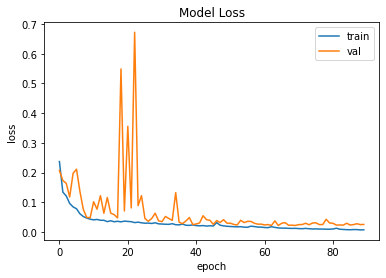

In [18]:
plot_loss_curve(resnet50_history)

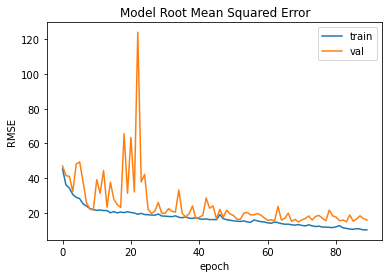

In [19]:
plot_rmse_metric_curve(resnet50_history)

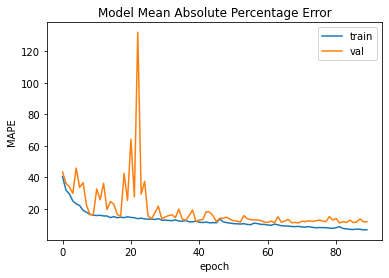

In [20]:
plot_mape_metric_curve(resnet50_history)

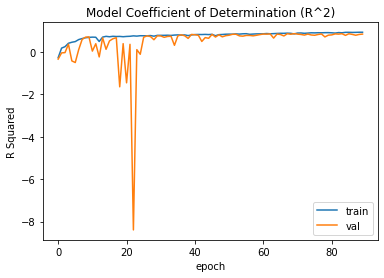

In [21]:
plot_r_squared_metric_curve(resnet50_history)

And finally, the evaluation results on the unseen testset are pretty good!

In [23]:
resnet50_score = resnet50_model.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("ResNet50 regressor evaluation results:\n")
print('Testset Loss = {:.5f}'.format(resnet50_score[0]))
print('Testset RMSE = {:.2f}'.format(resnet50_score[1]))
print('Testset MAPE = {:.2f} %'.format(resnet50_score[2]))
print('Testset Coefficient of Determination (R^2) = {:.2f} %'.format(resnet50_score[3]*100))

ResNet50 regressor evaluation results:

Testset Loss = 0.02358
Testset RMSE = 17.85
Testset MAPE = 12.20 %
Testset Coefficient of Determination (R^2) = 81.08 %


# Second Approach
## Inception-V4 For Bone Age Prediction

In this approach, we implement the InceptionV4 from scratch for the regression task.



**We consider the following points:**

- All hidden layers use GELU as their activation function
- The final layer uses Linear as its activation function
- The Adam optimizer is used to minimize the gradient
- The Mean Squared Logarithmic Error is used for the loss function
- The RMSE, MAPE and, R Squared metrics are used to evaluate model performance

In [11]:
class InceptionV4Regressor:

    def __init__(self, activation):
        self.activation = activation
        

    def __conv2d_with_batch(self, prev_layer, nbr_kernels, filter_size, strides=(1, 1), padding='valid'):
        X = tf.keras.layers.Conv2D(filters=nbr_kernels, kernel_size=filter_size, strides=strides, padding=padding)(prev_layer)
        X = tf.keras.layers.BatchNormalization()(X)
        return tf.keras.layers.Activation(activation=self.activation)(X)
    

    def __stem_block(self, prev_layer):
        X = self.__conv2d_with_batch(prev_layer, nbr_kernels=32, filter_size=(3, 3), strides=(2, 2))
        X = self.__conv2d_with_batch(X, nbr_kernels=32, filter_size=(3, 3))
        X = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(3, 3))
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(3, 3), strides=(2, 2))
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=96, filter_size=(3, 3))
        X_2 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(X_2, nbr_kernels=96, filter_size=(3, 3))
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=192, filter_size=(3, 3), strides=2)
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        return tf.keras.layers.concatenate([X_1, X_2], axis=3)
    

    def __reduction_A_block(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(3, 3), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 3), strides=(2, 2))
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(3, 3), strides=(2, 2))
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    

    def __reduction_B_block(self, prev_layer):
        X_1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=192, filter_size=(3, 3), strides=(2, 2))
        X_3 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(7, 1), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(3, 3), strides=(2, 2))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    

    def __inception_block_A(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=96, filter_size=(3, 3), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=96, filter_size=(1, 1), padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=96, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_B(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=192, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(7, 1), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=128, filter_size=(1, 1))
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_C(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=448, filter_size=(3, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=512, filter_size=(1, 3), padding='same')
        X_1_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_1_2 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_1 = tf.keras.layers.concatenate([X_1_1, X_1_2], axis=3)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_2_1 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_2_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_2 = tf.keras.layers.concatenate([X_2_1, X_2_2], axis=3)
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=3, padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)
    

    def __InceptionV4(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)
        
        X = self.__stem_block(prev_layer=input_layer)
        
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        
        X = self.__reduction_A_block(prev_layer=X)
        
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        
        X = self.__reduction_B_block(prev_layer=X)
        
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        
        output = tf.keras.layers.GlobalAveragePooling2D()(X)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=output, name='InceptionV4')

    def create_model(self, input_shape):
        base_model = self.__InceptionV4(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dropout(rate=0.2)(fc)
        fc = tf.keras.layers.Dense(1, activation='linear')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='InceptionV4_Regressor')
    
    
prepared_inceptionv4_model = InceptionV4Regressor(activation='gelu').create_model(input_shape=(SIZE, SIZE, 3))    

2023-02-13 10:36:58.865996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 10:36:58.866479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 10:36:58.867336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 10:36:58.868006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Here we summarize the model and architecture.

In [29]:
prepared_inceptionv4_model.summary()

Model: "InceptionV4_Regressor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 127, 127, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_149 (BatchN (None, 127, 127, 32) 128         conv2d_149[0][0]                 
__________________________________________________________________________________________________
activation_198 (Activation)     (None, 127, 127, 32) 0           batch_normalization_149[0][0]    
______________________________________________________________________________

Our model has more than `50` million parameters!

Then we plot the model architecture for better understanding.

In [30]:
tf.keras.utils.plot_model(prepared_inceptionv4_model, show_shapes=True, to_file='inceptionv4.png')

In this function, we train our model with the chosen hyperparameters and save the trained model for future uses.

In [15]:
def train_inceptionv4_model(prepared_model, training_data, optimizer='adam', loss_fn='mean_squared_logarithmic_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), r_squared], callbacks=[es], num_epochs=100):
    files = get_file_name('/kaggle/working/')
    if 'inceptionv4regressor.h5' in files:
        prepared_model = tf.keras.models.load_model('/kaggle/working/inceptionv4regressor.h5', custom_objects={'r_squared': r_squared})
        history = np.load('/kaggle/working/inceptionv4history.npy', allow_pickle=True).item()
    else:
        prepared_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
        history = prepared_model.fit(training_data, epochs=num_epochs, callbacks=callbacks, steps_per_epoch=train_steps, validation_data=validation_dataset, validation_steps=val_steps)
        prepared_model.save('/kaggle/working/inceptionv4regressor.h5')
        np.save('/kaggle/working/inceptionv4history.npy', history.history)
    return prepared_model, history


inceptionv4_model, inceptionv4_history = train_inceptionv4_model(prepared_inceptionv4_model, train_dataset, num_epochs=100)

2023-02-13 10:38:27.173057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-13 10:38:56.990183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


395/395 [==============================] - 252s 545ms/step - loss: 3.6109 - root_mean_squared_error: 113.8763 - mean_absolute_percentage_error: 75.6597 - r_squared: -7.5453 - val_loss: 0.4819 - val_root_mean_squared_error: 71.5776 - val_mean_absolute_percentage_error: 52.0447 - val_r_squared: -2.1559
Epoch 2/100
395/395 [==============================] - 208s 526ms/step - loss: 0.2348 - root_mean_squared_error: 52.3318 - mean_absolute_percentage_error: 41.7117 - r_squared: -0.7326 - val_loss: 0.1990 - val_root_mean_squared_error: 45.7805 - val_mean_absolute_percentage_error: 42.1007 - val_r_squared: -0.2705
Epoch 3/100
395/395 [==============================] - 208s 527ms/step - loss: 0.1838 - root_mean_squared_error: 43.7328 - mean_absolute_percentage_error: 40.4820 - r_squared: -0.1991 - val_loss: 0.1893 - val_root_mean_squared_error: 41.5160 - val_mean_absolute_percentage_error: 43.5561 - val_r_squared: -0.0328
Epoch 4/100
395/395 [==============================] - 207s 525ms/step -

We can observe the loss and metric curves which are satisfiable.

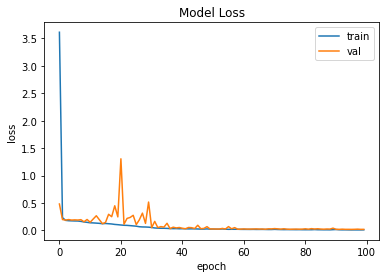

In [16]:
plot_loss_curve(inceptionv4_history)

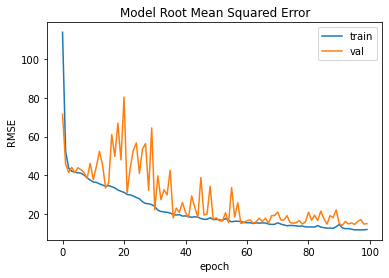

In [17]:
plot_rmse_metric_curve(inceptionv4_history)

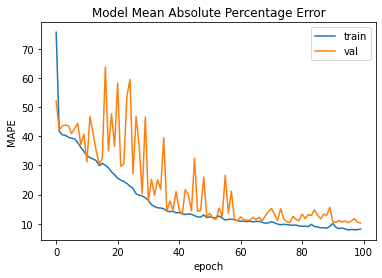

In [18]:
plot_mape_metric_curve(inceptionv4_history)

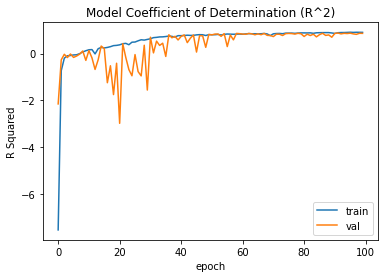

In [19]:
plot_r_squared_metric_curve(inceptionv4_history)

And finally, the evaluation results on the unseen testset are pretty good even better than ResNet-50!

In [25]:
inceptionv4_score = inceptionv4_model.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("Inception V4  regressor evaluation results:\n")
print('Testset Loss = {:.5f}'.format(inceptionv4_score[0]))
print('Testset RMSE = {:.2f}'.format(inceptionv4_score[1]))
print('Testset MAPE = {:.2f} %'.format(inceptionv4_score[2]))
print('Testset Coefficient of Determination (R^2) = {:.2f} %'.format(inceptionv4_score[3]*100))

Inception V4  regressor evaluation results:

Testset Loss = 0.02094
Testset RMSE = 15.09
Testset MAPE = 9.83 %
Testset Coefficient of Determination (R^2) = 86.34 %


## Conclusion

Both of the models showed a good result in the performance evaluation, but Inception-V4 results are slightly better than ResNet-50.

### Part Two: Transfer Learnin Phase

In this part we use transfer learning technique and load the trained model to perform a prediction task on the testset.

In [2]:
import os
import re
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices('GPU')

2023-02-13 20:50:14.144881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 20:50:14.232976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 20:50:14.233786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def get_file_name(dir):
    return os.listdir(dir)

def get_file_absolute_path(dir):
    file_names = os.listdir(dir)
    file_absolute_path = []
    for file_name in file_names:
        file_absolute_path.append(dir + file_name)
    return file_absolute_path

In [5]:
dir_root = '/kaggle/input/human-data-dataset/Bone Age Dataset/Bone Age Dataset/'

training_root = 'Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/'
test_root = 'Bone Age Test Set/'

data_path = 'data/'
label_path = 'labels/'

training_dataset_path = dir_root + training_root + data_path
validation_dataset_path = dir_root + validation_root + data_path
test_dataset_path = dir_root + test_root + data_path

training_labels_path = dir_root + training_root + label_path
validation_labels_path = dir_root + validation_root + label_path
test_labels_path = dir_root + test_root + label_path

In [6]:
training_labels = pd.read_csv(training_labels_path + get_file_name(training_labels_path)[0]).drop(columns=['male'])
validation_labels = pd.read_csv(validation_labels_path + get_file_name(validation_labels_path)[0]).drop(columns=['male'])
test_labels = pd.read_csv(test_labels_path + get_file_name(test_labels_path)[0]).drop(columns=['Sex'])

def convert_pandas_label_to_dict(dataframe):
    np_array = dataframe.values
    result = {}
    for indx, value in np_array:
        result[int(indx)] = value
    return result

training_labels = convert_pandas_label_to_dict(training_labels)
validation_labels = convert_pandas_label_to_dict(validation_labels)
test_labels = convert_pandas_label_to_dict(test_labels)

In [7]:
def create_dataset_datafram(dir, labels):
    data_container = {}
    paths = get_file_absolute_path(dir)
    for path in paths:
        data_container[path] = labels[int(re.findall('[0-9]+', path)[0])]
    return pd.DataFrame(list(data_container.items()), columns = ['file_absolute_path', 'label'])

training_dataframe = create_dataset_datafram(training_dataset_path, training_labels)
validation_dataframe = create_dataset_datafram(validation_dataset_path, validation_labels)
test_dataframe = create_dataset_datafram(test_dataset_path, test_labels)

In [8]:
SIZE = 256
batch_size = 32

training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255.)
val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_dataset = training_data_generator.flow_from_dataframe(
    dataframe=training_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    classes=None,
    class_mode='raw')

validation_dataset = val_data_generator.flow_from_dataframe(
    dataframe=validation_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=None,
    shuffle=False,
    classes=None,
    class_mode='raw')

test_dataset = val_data_generator.flow_from_dataframe(
    dataframe=test_dataframe,
    directory=None,
    x_col="file_absolute_path",
    y_col="label",
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    batch_size=batch_size,
    seed=None,
    shuffle=False,
    classes=None,
    class_mode='raw')

Found 12611 validated image filenames.
Found 1425 validated image filenames.
Found 200 validated image filenames.


Batch size: 32
X_train shape: (32, 256, 256, 3)
y_train shape: (32,)
X_val shape: (32, 256, 256, 3)
y_val shape: (32,)
X_test shape: (32, 256, 256, 3)
y_test shape: (32,)


LABEL: 117.98716104086928


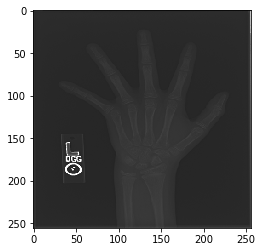



LABEL: 199.34490396930036


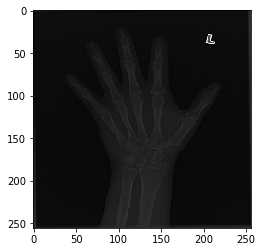



LABEL: 93.62925976248292


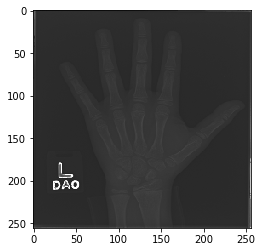

In [9]:
print('Batch size: ' + str(batch_size))
X_train_sample = train_dataset.__getitem__(0)[0]
y_train_sample = train_dataset.__getitem__(0)[1]
print ('X_train shape: '  + str(X_train_sample.shape))
print ('y_train shape: ' + str(y_train_sample.shape))
X_val_sample = validation_dataset.__getitem__(0)[0]
y_val_sample = validation_dataset.__getitem__(0)[1]
print ('X_val shape: '  + str(X_val_sample.shape))
print ('y_val shape: ' + str(y_val_sample.shape))
index = random.randint(0, 5)
X_test_sample = test_dataset.__getitem__(index)[0]
y_test_sample = test_dataset.__getitem__(index)[1]
print ('X_test shape: '  + str(X_test_sample.shape))
print ('y_test shape: ' + str(y_test_sample.shape))
print("\n")

def plot_image(X_input, labels):
    plt.imshow(X_input, cmap=plt.cm.gray_r, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

for i in range(3):
    plot_image(X_test_sample[i], y_test_sample[i])
    print("\n")

In [10]:
def load_pretrained_model(model_name):
    name_builder = '/kaggle/input/human-data-dataset/' + model_name
    prepared_model = tf.keras.models.load_model(name_builder + 'regressor.h5', custom_objects={'r_squared': r_squared})
    history = np.load(name_builder + 'history.npy', allow_pickle=True).item()
    return prepared_model, history

In [11]:
def r_squared(y_true, y_pred):
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    return 1. - tf.divide(unexplained_error, total_error)

In [12]:
resnet50_model, resnet50_history = load_pretrained_model('resnet50')

2023-02-13 20:51:31.947046: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 20:51:31.947509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 20:51:31.948408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 20:51:31.949102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [13]:
inceptionv4_model, inceptionv4_history = load_pretrained_model('inceptionv4')

In [14]:
test_steps = int(np.ceil(test_dataset.n / batch_size))

In [15]:
resnet50_predictions = resnet50_model.predict(test_dataset, steps=test_steps)

2023-02-13 20:52:02.925148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-13 20:52:05.194850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [16]:
inceptionv4_predictions = inceptionv4_model.predict(test_dataset, steps=test_steps)

In [17]:
def mean_of_errors(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def get_test_labels(dataset):
    number_of_generator_calls = math.ceil(dataset.n / (1.0 * batch_size))
    dataset_labels = []
    for i in range(0, int(number_of_generator_calls)):
        dataset_labels.extend(np.array(dataset[i][1]))
    return np.array(dataset_labels, dtype='float32').reshape(200, 1)

In [18]:
resne50_mean_errors = mean_of_errors(get_test_labels(test_dataset), resnet50_predictions)
print('The mean of difference between true labels and predicted labels for testset for ResNet-50 is: {:.2f}'.format(resne50_mean_errors))

inceptionv4_mean_errors = mean_of_errors(get_test_labels(test_dataset), inceptionv4_predictions)
print('The mean of difference between true labels and predicted labels for testset for InceptionV4 is: {:.2f}'.format(inceptionv4_mean_errors))

The mean of difference between true labels and predicted labels for testset for ResNet-50 is: 13.92
The mean of difference between true labels and predicted labels for testset for InceptionV4 is: 11.32


We can say that the mean error of ResNet-50 for Testset is **13.92 month**.

We can say that the mean error of InceptionV4 for Testset is **11.32 month**.